Cross Entropy method is a precursor to advanced methods like DQN, A2C etc. its implementation is easy and has good convergence for simple environments with no complex rules. \
this is a model free, policy based , on policy method. \
Model free : no internal model of the observation / reward. a mapping function from observation+reward to the action space. \
policy based : the model returns the probability across action space directly after reading the observation and rewards \
On policy method : required fresh data based on the adopted policy for training and cannot rely on historical data.

In practice, the agent's behaviour of interacting with the environment is modelled by a neural network with a non-linear activation function. the nn basically returns a probability distribution over action space. the action is chosen from the probability distribution with some amount of randomness since it encourages the agent to explore the environment initially. \
During the agent's lifetime, its experience is presented as episodes. \
The core of cross entopy method is to throw away bad episodes and learn from the episodes where it performed better to maximize its likelihood of performing better in future.

Algorithm:
1. Run N episodes with the current neural network. \
2. Calculate the total reward for every episode and decide on the reward threshold. Usually 50th or 70th percentile is chosen.
3. Discard the ones below this threshold and train the NN on the remaining elite ones
4. Repeat the process till satisfactory levels have achieved. \
The algorithm is easier to implement and train and works well for simple environments. the reward boundary becomes higher and higher and thus goes high the performance of the agents.

In [ ]:
# Cross entropy on Cartpole gym environment
import numpy as np
import gymnasium as gym
from dataclasses import dataclass
import typing as tt
from torch.utils.tensorboard.writer import SummaryWriter

import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
HIDDEN_SIZE = 128
BATCH_SIZE = 16
PERCENTILE = 70

In [ ]:
class Net(nn.Module):
  def __init__(self,obs_size : int, hidden_size : int, n_actions : int):
    super(Net,self).__init__()
    # a simple network
    self.net = nn.Sequential(
        nn.Linear(obs_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, n_actions)
    )
  def forward(self, x):
      return self.net(x)


In [ ]:
@dataclass
class EpisodeStep:
  observation : np.ndarray
  action : int

@dataclass
class Episode:
  reward : float
  steps : tt.List[EpisodeStep]


In [ ]:
def iterate_batches(env : gym.Env, net : Net, batch_size : int):
  batch = []
  episode_steps = []
  episode_reward = 0.0
  obs, _ = env.reset()
  sm = nn.Softmax(dim=1)
  while True:
    obs_v = torch.tensor(obs, dtype=torch.float32)
    act_probs_v = sm(net(obs_v.unsqueeze(0)))
    act_probs = act_probs_v.data.numpy()[0]
    action = np.random.choice(len(act_probs), p=act_probs)
    next_obs, reward, terminated, truncated, _ = env.step(action)
    episode_reward += reward
    episode_steps.append(EpisodeStep(observation=obs, action=action))
    if terminated or truncated:
      batch.append(Episode(reward=episode_reward, steps = episode_steps))
      episode_reward = 0.0
      episode_steps = []
      next_obs, _ = env.reset()
      if len(batch) == batch_size:
        yield batch
        batch = []
    obs = next_obs



In [ ]:
def filter_batch(batch, percentile):
  rewards = list(map(lambda s : s.reward, batch)) # extract reward from batch
  reward_bound = np.percentile(rewards,percentile) # find the 70th percentile data
  reward_mean = float(np.mean(rewards))
  train_obs = []
  train_act = []
  for episode in batch:
    if episode.reward < reward_bound:
      continue
    train_obs.extend(map(lambda step : step.observation, episode.steps))
    train_act.extend(map(lambda step : step.action, episode.steps))
  train_obs_v = torch.FloatTensor(np.vstack(train_obs))
  train_act_v = torch.LongTensor(train_act)
  return train_obs_v, train_act_v, reward_bound, reward_mean


In [ ]:
env = gym.make("CartPole-v1")
assert env.observation_space.shape is not None
obs_size = env.observation_space.shape[0]
assert isinstance(env.action_space, gym.spaces.Discrete)
n_action = int(env.action_space.n)

In [ ]:
net = Net(obs_size, HIDDEN_SIZE, n_action)
print(net)
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(params = net.parameters(), lr=0.01)
losses = []
reward_bounds = []
reward_means = []
for iter_no, batch in enumerate(iterate_batches(env,net,BATCH_SIZE)):
  obs_v, act_v, reward_b, reward_m = filter_batch(batch, PERCENTILE)
  optimizer.zero_grad()
  action_scores_v = net(obs_v)
  loss_v = objective(action_scores_v, act_v)
  loss_v.backward()
  optimizer.step()
  print("%d: loss=%.3f, reward_mean=%.1f, rw_bound=%.1f" % (
            iter_no, loss_v.item(), reward_m, reward_b))
  losses.append(loss_v.item())
  reward_bounds.append(reward_b)
  reward_means.append(reward_m)
  if reward_m > 475: # termination condtition deemed satisfactory
     print("solved")
     break


Net(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
)
0: loss=0.693, reward_mean=25.7, rw_bound=29.5
1: loss=0.677, reward_mean=27.9, rw_bound=28.0
2: loss=0.675, reward_mean=30.2, rw_bound=37.0
3: loss=0.662, reward_mean=34.8, rw_bound=37.0
4: loss=0.662, reward_mean=30.3, rw_bound=36.5
5: loss=0.667, reward_mean=34.0, rw_bound=45.0
6: loss=0.649, reward_mean=38.3, rw_bound=47.0
7: loss=0.628, reward_mean=39.0, rw_bound=43.5
8: loss=0.634, reward_mean=38.7, rw_bound=47.5
9: loss=0.631, reward_mean=52.0, rw_bound=61.0
10: loss=0.611, reward_mean=54.9, rw_bound=55.0
11: loss=0.610, reward_mean=47.1, rw_bound=53.0
12: loss=0.604, reward_mean=50.0, rw_bound=56.5
13: loss=0.606, reward_mean=54.3, rw_bound=56.0
14: loss=0.606, reward_mean=50.8, rw_bound=58.0
15: loss=0.601, reward_mean=51.5, rw_bound=59.0
16: loss=0.585, reward_mean=56.1, rw_bound=59.5
17: loss=0.573, reward_mea

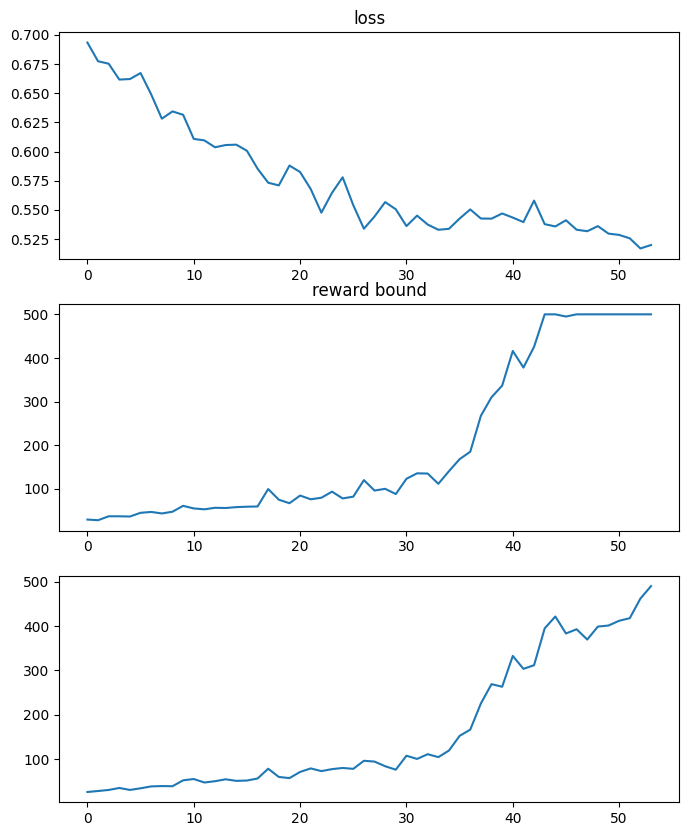

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8, 10))
ax[0].plot(losses)
ax[0].set_title("loss")
ax[1].plot(reward_bounds)
ax[1].set_title("reward bound")
ax[2].plot(reward_means)

In [ ]:
# Frozen lake problem
e = gym.make("FrozenLake-v1", render_mode="ansi")
print(e.action_space)
print(e.observation_space)

Discrete(4)
Discrete(16)


In [ ]:
e.reset()

(0, {'prob': 1})

In [ ]:
print(e.render())


SFFF
FHFH
FFFH
HFFG



The environment is a grid of 16 cells numbered from 0 to 15. the observation space is discrete with the grid cell number given to us. the action space is a discrete set similar to cart pole environment. To reuse cartpole's neural network and trainer object, we could one hot the observation space to get a 16 dimensional sparse vector

In [ ]:
class DiscreteOneHotWrapper(gym.ObservationWrapper):
  def __init__(self, env:gym.Env):
    super(DiscreteOneHotWrapper, self).__init__(env)
    assert isinstance(env.observation_space, gym.spaces.Discrete)
    shape = (env.observation_space.n, )
    self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=shape, dtype=np.float32)
  def observation(self,observation):
    res = np.copy(self.observation_space.low) # returns an array of shape equal to observation_space.n with values set to lower bound
    res[observation] = 1.0
    return res




We are reusing the iterate_batches and filter_batches from CartPole problem since we have now modified the observation space to have the same structure

In [ ]:
env = DiscreteOneHotWrapper(gym.make("FrozenLake-v1"))
assert env.observation_space.shape is not None
obs_size = env.observation_space.shape[0]
assert isinstance(env.action_space, gym.spaces.Discrete)
n_action = int(env.action_space.n)


In [ ]:
print(obs_size)

16


In [ ]:
net = Net(obs_size, HIDDEN_SIZE, n_action)
print(net)
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(params = net.parameters(), lr=0.01)
losses = []
reward_bounds = []
reward_means = []
for iter_no, batch in enumerate(iterate_batches(env,net,BATCH_SIZE)):
  obs_v, act_v, reward_b, reward_m = filter_batch(batch, PERCENTILE)
  optimizer.zero_grad()
  action_scores_v = net(obs_v)
  loss_v = objective(action_scores_v, act_v)
  loss_v.backward()
  optimizer.step()
  print("%d: loss=%.3f, reward_mean=%.1f, rw_bound=%.1f" % (
            iter_no, loss_v.item(), reward_m, reward_b))
  losses.append(loss_v.item())
  reward_bounds.append(reward_b)
  reward_means.append(reward_m)
  if reward_m > 0.8: # termination condtition deemed satisfactory
     print("solved")
     break
  if iter_no > 5000:
    print("iteration limit reached!")


Streaming output truncated to the last 5000 lines.
17: loss=1.319, reward_mean=0.0, rw_bound=0.0
18: loss=1.276, reward_mean=0.0, rw_bound=0.0
19: loss=1.303, reward_mean=0.1, rw_bound=0.0
20: loss=1.296, reward_mean=0.1, rw_bound=0.0
21: loss=1.295, reward_mean=0.0, rw_bound=0.0
22: loss=1.299, reward_mean=0.0, rw_bound=0.0
23: loss=1.333, reward_mean=0.0, rw_bound=0.0
24: loss=1.250, reward_mean=0.0, rw_bound=0.0
25: loss=1.247, reward_mean=0.0, rw_bound=0.0
26: loss=1.313, reward_mean=0.0, rw_bound=0.0
27: loss=1.341, reward_mean=0.0, rw_bound=0.0
28: loss=1.334, reward_mean=0.1, rw_bound=0.0
29: loss=1.269, reward_mean=0.1, rw_bound=0.0
30: loss=1.258, reward_mean=0.0, rw_bound=0.0
31: loss=1.246, reward_mean=0.0, rw_bound=0.0
32: loss=1.268, reward_mean=0.1, rw_bound=0.0
33: loss=1.343, reward_mean=0.0, rw_bound=0.0
34: loss=1.222, reward_mean=0.1, rw_bound=0.0
35: loss=1.240, reward_mean=0.1, rw_bound=0.0
36: loss=1.270, reward_mean=0.0, rw_bound=0.0
37: loss=1.210, reward_mean=0

KeyboardInterrupt: 

some fundamental points to note:
1. there is no improvement in scores over time, though loss function is gradually decreasing.
2. this is due to the way rewards are obtained. in cartpole, every state other than the pole falling off is rewarded with 1 , so you could accumulate rewards over time and thus there was a way to quantify how good our episode was.  Different episodes had different rewards due to the neural network random initialization in the beginning but as we had elite episodes to train on, the network trained to balance longer.
3. but in frozen lake, we have reward only at the end, and it is plain 1 from which we cannot extract if the episode was optimal, consumed less time etc.
4. and it is very rare to get a episode where the agent succeeds. So, there are not enough elite episodes to train the agent. bad episodes creep in as elite episodes and thus there is no improvement in agent's behaviour.
5. This gives a glimpse of limitation of cross entropy method. it requires environments which offer rewards periodically and not just at the end. there has to be a good variability between good and bad episodes for it to choose elite episodes and train on them.

Some ways of mitigating the problem:
1.Use a larger batch size. use a batch of 100 episodes or more to have higher probability of getting episodes with reward 1 and thus more elite episodes to train on.
2. need more variability of episodes .So we could discount factor in total reward which shorter episodes have higher reward and longer episodes have lower rewards
3.do not throw away elite episodes after using it once for training.use it for several iterations.
4. Decrease the learning rate to train on more samples
5. Much longer training time

In [ ]:
HIDDEN_SIZE = 128
BATCH_SIZE = 100
PERCENTILE = 30
GAMMA = 0.9

In [ ]:
def filter_batch_better(batch, percentile):
  reward_func = lambda s : s.reward * (GAMMA ** len(s.steps)) # discount reward for longer time steps
  rewards = list(map(reward_func, batch))
  reward_bound = np.percentile(rewards,percentile)

  train_obs = []
  train_act = []
  elite_batch = []
  for episode, reward in zip(batch, rewards):
    if reward > reward_bound:
      train_obs.extend(map(lambda step : step.observation, episode.steps))
      train_act.extend(map(lambda step : step.action, episode.steps))
      elite_batch.append(episode)
  return elite_batch, train_obs, train_act, reward_bound


In [ ]:
env = DiscreteOneHotWrapper(gym.make("FrozenLake-v1"))
obs_size = env.observation_space.shape[0]
n_actions = env.action_space.n

net = Net(obs_size, HIDDEN_SIZE, n_actions)
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=net.parameters(), lr=0.001) # learning rate is reduced by a factor of 10

In [ ]:
full_batch = []
losses = []
reward_bounds = []
reward_means = []
for iter_no, batch in enumerate(iterate_batches(env, net, BATCH_SIZE)):
  reward_mean = float(np.mean(list(map(lambda s: s.reward, batch))))
  full_batch, obs, acts, reward_bound = filter_batch_better(full_batch + batch, PERCENTILE) # append current batch to a batch repository
  if not full_batch:
    continue
  obs_v = torch.FloatTensor(np.vstack(obs))
  acts_v = torch.LongTensor(acts)
  full_batch = full_batch[-500:]

  optimizer.zero_grad()
  action_scores_v = net(obs_v)
  loss_v = objective(action_scores_v, acts_v)
  loss_v.backward()
  optimizer.step()

  print("%d: loss=%.3f, rw_mean=%.3f, "
              "rw_bound=%.3f, batch=%d" % (
            iter_no, loss_v.item(), reward_mean,
            reward_bound, len(full_batch)))
  losses.append(loss_v.item())
  reward_bounds.append(reward_bound)
  reward_means.append(reward_mean)
  if reward_mean > 0.8:
    print("solved")
    break
  if iter_no > 5000:
    break



0: loss=1.371, rw_mean=0.030, rw_bound=0.000, batch=3
1: loss=1.372, rw_mean=0.020, rw_bound=0.000, batch=5
2: loss=1.368, rw_mean=0.000, rw_bound=0.000, batch=5
3: loss=1.379, rw_mean=0.020, rw_bound=0.000, batch=7
4: loss=1.375, rw_mean=0.000, rw_bound=0.000, batch=7
5: loss=1.372, rw_mean=0.020, rw_bound=0.000, batch=9
6: loss=1.369, rw_mean=0.000, rw_bound=0.000, batch=9
7: loss=1.366, rw_mean=0.020, rw_bound=0.000, batch=11
8: loss=1.368, rw_mean=0.010, rw_bound=0.000, batch=12
9: loss=1.368, rw_mean=0.040, rw_bound=0.000, batch=16
10: loss=1.368, rw_mean=0.060, rw_bound=0.000, batch=22
11: loss=1.365, rw_mean=0.020, rw_bound=0.000, batch=24
12: loss=1.365, rw_mean=0.010, rw_bound=0.000, batch=25
13: loss=1.364, rw_mean=0.010, rw_bound=0.000, batch=26
14: loss=1.361, rw_mean=0.020, rw_bound=0.000, batch=28
15: loss=1.358, rw_mean=0.020, rw_bound=0.000, batch=30
16: loss=1.357, rw_mean=0.030, rw_bound=0.000, batch=33
17: loss=1.355, rw_mean=0.030, rw_bound=0.000, batch=36
18: loss=

KeyboardInterrupt: 

with the tweaks, we see an improvement in the rewards now, it consistently touches 0.4 and with some more tweaks and training time, we can expect to get 0.8.